In [ ]:
pip install tableone

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats.kde import gaussian_kde

from tableone import TableOne

class TreatmentEffect:
    def __init__(self, X_var, Tr, Y, Estimator = "Logit",  threshold = 5e-2, nmatches = 1):
        self.X_var = X_var
        self.Tr = Tr
        self.Y = Y
        self.data = pd.concat([X_var, Tr, Y], axis = 1)
        self.data.columns = X_var.columns.tolist() + ['Tr', 'Y']
        self.Estimator = Estimator
        self.threshold = threshold
        self.nmatches = nmatches


    def getObsTE(self):
        trUnits = self.data[self.data['Tr']== 1]
        EY_tr= trUnits['Y'].mean()
        ctrlUnits = self.data[self.data['Tr'] == 0]
        EY_ctrl = ctrlUnits['Y'].mean()
        self.Obs_ATE = EY_tr - EY_ctrl
        return EY_tr, EY_ctrl
            
    
    def TableOneBefore(self):
        table_data = self.data
        columns = self.X_var.columns.tolist()
        table_data.reset_index(drop=True, inplace=True)
        mytable = TableOne(table_data, columns = columns, groupby = "Tr", pval = True) 
        mytable.to_excel('TableOneBefore.xlsx')
        return mytable
    

    def ps_estimate(self):
        X_colnames = self.X_var.columns.tolist()
        if self.Estimator == "Logit":
            ps_model = LogisticRegression(C=1e6).fit(self.data[X_colnames], self.data['Tr'])
            ps_hat = ps_model.predict_proba(self.data[X_colnames])[:, 1]
        elif self.Estimator == "RandomForest":
            ps_RF = RandomForestClassifier()
            ps_RF.fit(self.data[X_colnames], self.data['Tr'])
            ps_hat = ps_RF.predict_proba(self.data[X_colnames])[:,1]
        elif self.Estimator == "GradientBoosting":
            ps_gbm = GradientBoostingClassifier()
            ps_gbm.fit(self.data[X_colnames], self.data['Tr'])
            ps_hat = ps_gbm.predict_proba(self.data[X_colnames])[:,1]
        return ps_hat
    
        
    def matching(self):
        ps_hat = self.ps_estimate()
        ps_df = pd.DataFrame(ps_hat, columns = ['ps_hat'])
        data_ps = pd.concat([self.data, ps_df], axis = 1)
        treat_scores = data_ps[data_ps['Tr']==1][['ps_hat']]
        ctrl_scores = data_ps[data_ps['Tr']==0][['ps_hat']]
        result, match_ids = [], []
        for i in range(len(treat_scores)):
            score = treat_scores.iloc[i]
            bool_match = abs(ctrl_scores - score) <= self.threshold
            matches = ctrl_scores.loc[bool_match[bool_match.ps_hat].index]
            if len(matches) == 0:
                continue
            select = self.nmatches 
            chosen = np.random.choice(matches.index, min(select, self.nmatches), replace=False)
            result.extend([treat_scores.index[i]] + list(chosen))
            match_ids.extend([i] * (len(chosen)+1))
        matched_data = data_ps.loc[result]
        matched_data['match_id'] = match_ids
        matched_data['record_id'] =  matched_data.index
        return matched_data 
    
    
    def TableOneAfter(self):
        matched_data = self.matching()
        columns = self.X_var.columns.tolist()
        matched_table_data = matched_data.drop(['match_id', 'ps_hat', 'record_id'], axis = 1)
        matched_table_data.reset_index(drop=True, inplace=True)
        matched_table_data.index = range(1,matched_table_data.shape[0]+1)
        mytable = TableOne(matched_table_data, columns = columns, groupby = "Tr", pval = True) 
        mytable.to_excel('TableOneAfter.xlsx')
        return mytable

    
    def getATE(self):
        matched_data = self.matching()
        matched_EY_treated = matched_data['Y'][matched_data['Tr']==1].mean()
        matched_EY_ctrl = matched_data['Y'][matched_data['Tr']==0].mean()
        self.Caus_ATE = matched_EY_ctrl - matched_EY_ctrl
        return(matched_EY_treated, matched_EY_ctrl)
            
        
    def densityPoints(self):
        matchingData = self.matching()
        graph = []
        for j in range(self.X_var.shape[1]):
            colname_j = self.X_var.columns.values[j]

            controlData = self.data[self.data['Tr']== 0][colname_j].sort_values()
            controlDens = gaussian_kde(controlData).evaluate(controlData)
            Before_Ctrl = pd.DataFrame({'x':controlData,'y':controlDens}).drop_duplicates(subset = "x")

            treatedData = self.data[self.data['Tr']== 1][colname_j].sort_values()
            treatedDens = gaussian_kde(treatedData).evaluate(treatedData)
            Before_Tr = pd.DataFrame({'x':treatedData,'y':treatedDens}).drop_duplicates(subset = "x")

            matchedTreatedData = matchingData[matchingData['Tr']== 1][colname_j].sort_values()
            matchedTreatedDens = gaussian_kde(matchedTreatedData).evaluate(matchedTreatedData)
            After_Tr = pd.DataFrame({'x':matchedTreatedData,'y':matchedTreatedDens}).drop_duplicates(subset = "x")

            matchedControlData = matchingData[matchingData['Tr']== 0][colname_j].sort_values()
            matchedControlDens = gaussian_kde(matchedControlData).evaluate(matchedControlData)
            After_Ctrl = pd.DataFrame({'x':matchedControlData,'y':matchedControlDens}).drop_duplicates(subset = "x")

            graph.append({"ForHeader":colname_j, "Tables": 
                {"BeforeMatching":
                {"DataControl": Before_Ctrl["x"], "meanControl": controlData.mean(), "DensityControl": Before_Ctrl["y"], 
                 "DataTreated": Before_Tr["x"], "meanTreated": treatedData.mean(), "DensityTreated": Before_Tr["y"]},
                "AfterMatching": 
                {"DataControl": After_Ctrl["x"], "meanControl": matchedControlData.mean(),  "DensityControl": After_Ctrl["y"],
                 "DataTreated": After_Tr["x"],  "meanTreated": matchedTreatedData.mean(), "DensityTreated": After_Tr["y"]}}})
        return(graph)
        

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
### Specifie X,T and Y
data = pd.read_csv("Synthetic_df.csv")

Tr = data['W']
Y = data['Y']
X = data[data.columns.drop(['Unnamed: 0','W', 'Y'])]

# Nouvelle section

## Test 1: default parameters.

In [ ]:
model = TreatmentEffect(X, Tr, Y)

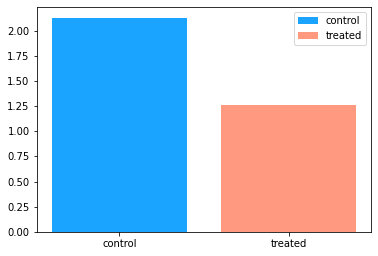

Mean_tr = 1.258425866261344
Mean_ctrl = 2.1296131425141107
The Observed treatment effect before Propensity Score Matching: -0.8711872762527668


In [ ]:
df_before = model.data                                                                          
ObsATElist = model.getObsTE()                                                                  
Mean_tr = ObsATElist[0]                                                                      
Mean_ctrl = ObsATElist[1]                                                                   

# Add a barplot
bars = ('control', 'treated')
height = [Mean_ctrl, Mean_tr]
y_pos = np.arange(len(bars))

plt.bar(y_pos[0], height[0], color="#1AA3FF", label=bars[0])
plt.bar(y_pos[1], height[1], color="#FF9980", label=bars[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.legend()
plt.show()

ObsATE = Mean_tr - Mean_ctrl   
print("Mean_tr = " + str(Mean_tr))
print("Mean_ctrl = " + str(Mean_ctrl))                                                               
print("The Observed treatment effect before Propensity Score Matching: " + str(ObsATE))

In [ ]:
model.TableOneBefore()

Grouped by Tr                                            
                      Missing     Overall           0           1 P-Value
n                                   10000        4991        5009        
X.1, mean (SD)              0  -0.0 (1.0)  -0.4 (0.9)   0.4 (0.9)  <0.001
X.2, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.214
X.3, mean (SD)              0   0.0 (1.0)   0.0 (1.0)   0.0 (1.0)   0.517
X.4, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.313
X.5, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)   0.0 (1.0)   0.780

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

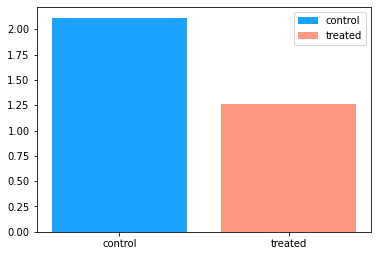

Mean_tr = 1.258425866261344
Mean_ctrl = 2.1128876177300073
The Causal treatment effect after Propensity Score Matching: -0.8544617514686634


In [ ]:
df_after = model.data
ATElist = model.getATE()
Mean_tr = ATElist[0]
Mean_ctrl = ATElist[1]

# Add a barplot
bars = ('control', 'treated')
height = [Mean_ctrl, Mean_tr]
y_pos = np.arange(len(bars))

plt.bar(y_pos[0], height[0], color="#1AA3FF", label=bars[0])
plt.bar(y_pos[1], height[1], color="#FF9980", label=bars[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.legend()
plt.show()

CausalATE = Mean_tr - Mean_ctrl
print("Mean_tr = " + str(Mean_tr))
print("Mean_ctrl = " + str(Mean_ctrl))
print("The Causal treatment effect after Propensity Score Matching: " + str(CausalATE))    

In [ ]:
model.TableOneAfter()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

Grouped by Tr                                            
                      Missing     Overall           0           1 P-Value
n                                   10018        5009        5009        
X.1, mean (SD)              0   0.4 (0.9)   0.4 (0.9)   0.4 (0.9)   0.502
X.2, mean (SD)              0  -0.0 (1.0)   0.0 (1.0)  -0.0 (1.0)   0.634
X.3, mean (SD)              0   0.0 (1.0)  -0.0 (1.0)   0.0 (1.0)   0.642
X.4, mean (SD)              0  -0.0 (1.0)   0.0 (1.0)  -0.0 (1.0)   0.569
X.5, mean (SD)              0   0.0 (1.0)   0.0 (1.0)   0.0 (1.0)   0.485

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

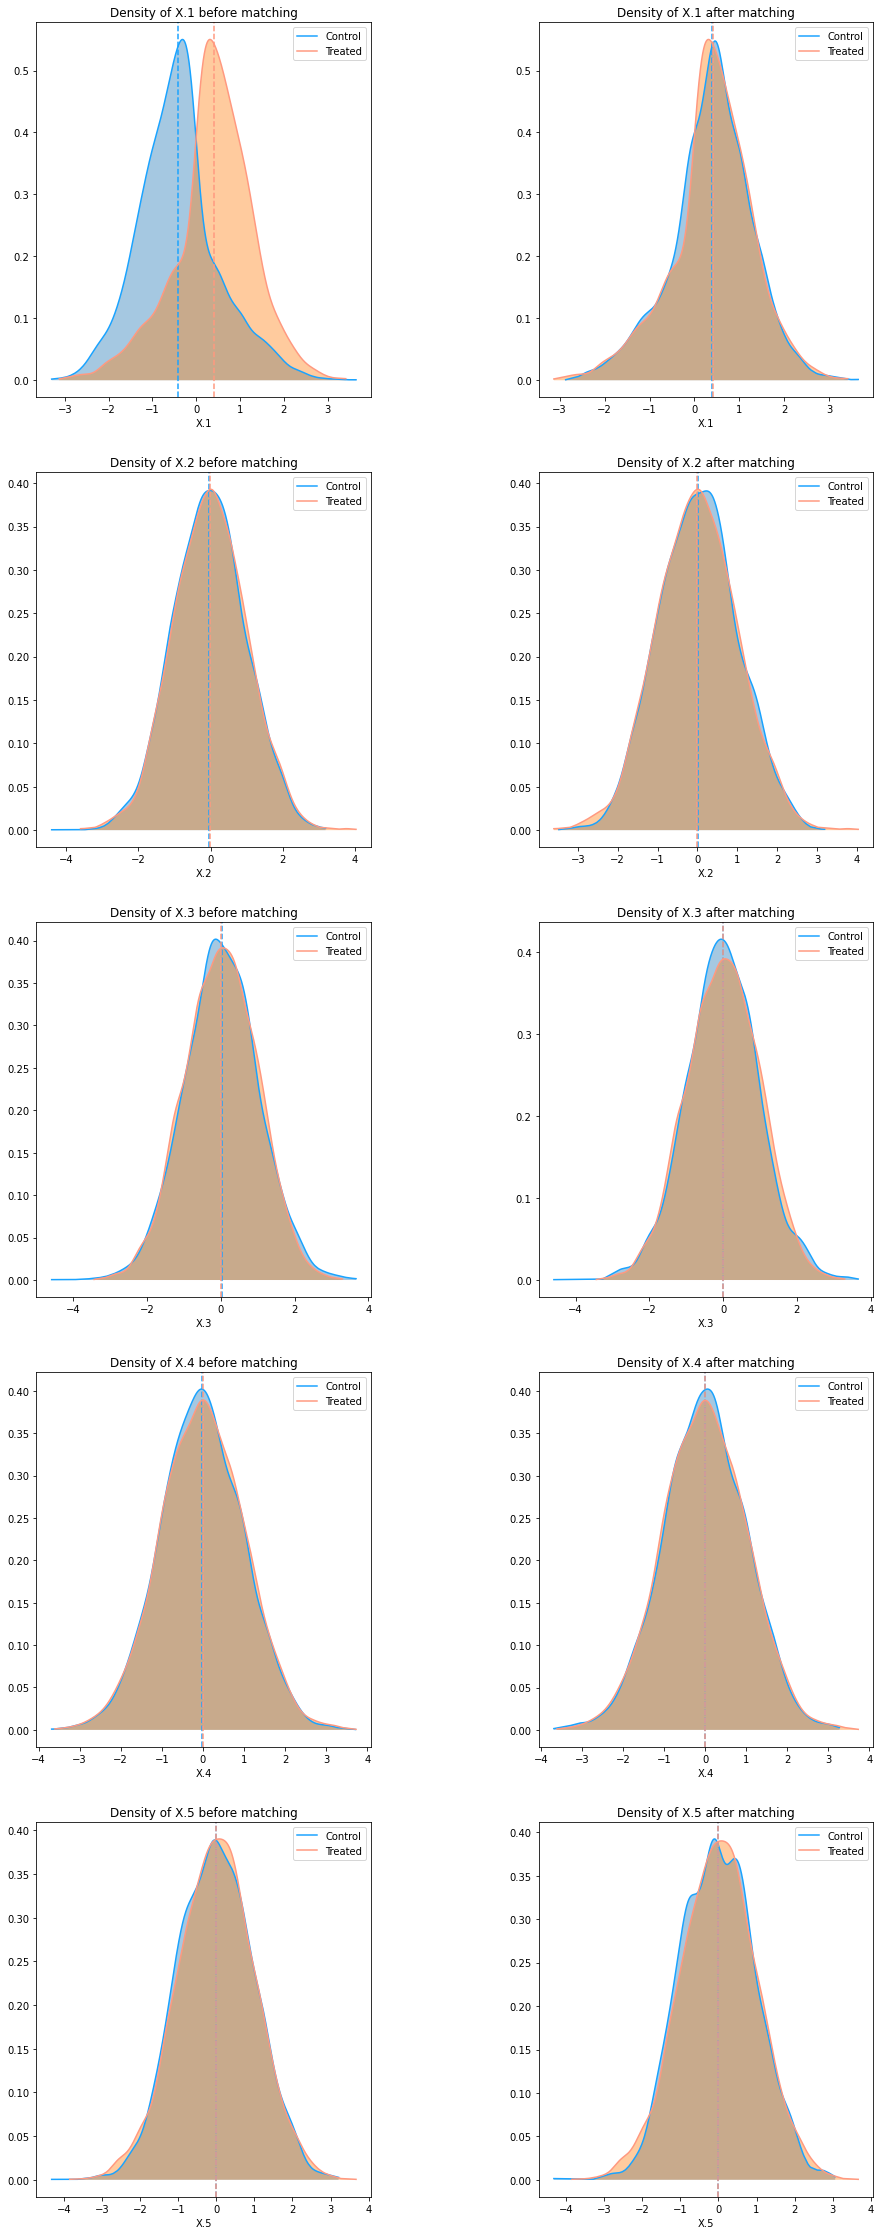

In [ ]:
graph = model.densityPoints()
fig, axs = plt.subplots(model.X_var.shape[1], 2, figsize=(model.X_var.shape[1]*3, model.X_var.shape[1]*8))
for j in range(model.X_var.shape[1]):    
    colname_j = model.X_var.columns.values[j] 
        
    # Plot the density of two population for absences before matching
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataControl"], graph[j]["Tables"]["BeforeMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataControl"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityControl"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 0].set_title("Density of " + colname_j + " before matching")
    axs[j, 0].set_xlabel(colname_j)
    axs[j, 0].legend();
            
    # Plot the density of two population for absences after matching
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataControl"], graph[j]["Tables"]["AfterMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataControl"], 0, graph[j]["Tables"]["AfterMatching"]["DensityControl"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataTreated"], graph[j]["Tables"]["AfterMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataTreated"], 0, graph[j]["Tables"]["AfterMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 1].set_title("Density of " +colname_j + " after matching")
    axs[j, 1].legend();
    axs[j, 1].set_xlabel(colname_j)
    plt.subplots_adjust(wspace=0.5, hspace=0.2)

In [ ]:
def getDensityGraph(matchingData: pd.DataFrame, X_var, data):

    graph = []
    for j in range(X_var.shape[1]):
        colname_j = X_var.columns.values[j]

        controlData = data[data['Tr'] == 0][colname_j].sort_values()
        treatedData = data[data['Tr'] == 1][colname_j].sort_values()
        matchedControlData = matchingData[matchingData['Tr'] == 0][colname_j].sort_values()
        matchedTreatedData = matchingData[matchingData['Tr'] == 1][colname_j].sort_values()

        kde = gaussian_kde(treatedData)
        treatedDens = kde.evaluate(treatedData)

        kde = gaussian_kde(controlData)
        controlDens = kde.evaluate(controlData)

        kde = gaussian_kde(matchedTreatedData)
        matchedTreatedDens = kde.evaluate(matchedTreatedData)

        kde = gaussian_kde(matchedControlData)
        matchedControlDens = kde.evaluate(matchedControlData)

        RawDataControl = pd.DataFrame({'data':controlData,'density':controlDens}).drop_duplicates(subset = 'data')
        RawDataTreated = pd.DataFrame({'data':treatedData,'density':treatedDens}).drop_duplicates(subset = "data")
        
        AfterMatchingControl = pd.DataFrame({'data':matchedControlData,'density':matchedControlDens}).drop_duplicates(subset = 'data')
        AfterMatchingTreated = pd.DataFrame({'data':matchedTreatedData,'density':matchedTreatedDens}).drop_duplicates(subset = 'data')


        graph.append({"ForHeader":colname_j, "Tables": 
            {"BeforeMatching":
                {"DataControl": RawDataControl['data'].to_list(),
                 "meanControl": controlData.mean(), 
                 "DensityControl": RawDataControl['density'].to_list(), 
                 "DataTreated": RawDataTreated['data'].to_list(), 
                 "meanTreated": treatedData.mean(), 
                 "DensityTreated": RawDataTreated['density'].to_list()},
            "AfterMatching": 
                {"DataControl": AfterMatchingControl['data'].to_list(),
                 "meanControl": matchedControlData.mean(), 
                 "DensityControl": AfterMatchingControl['density'].to_list(),
                 "DataTreated": AfterMatchingTreated['data'].to_list(), 
                 "meanTreated": matchedTreatedData.mean(),
                 "DensityTreated": AfterMatchingTreated['density'].to_list()}}})

    return graph

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

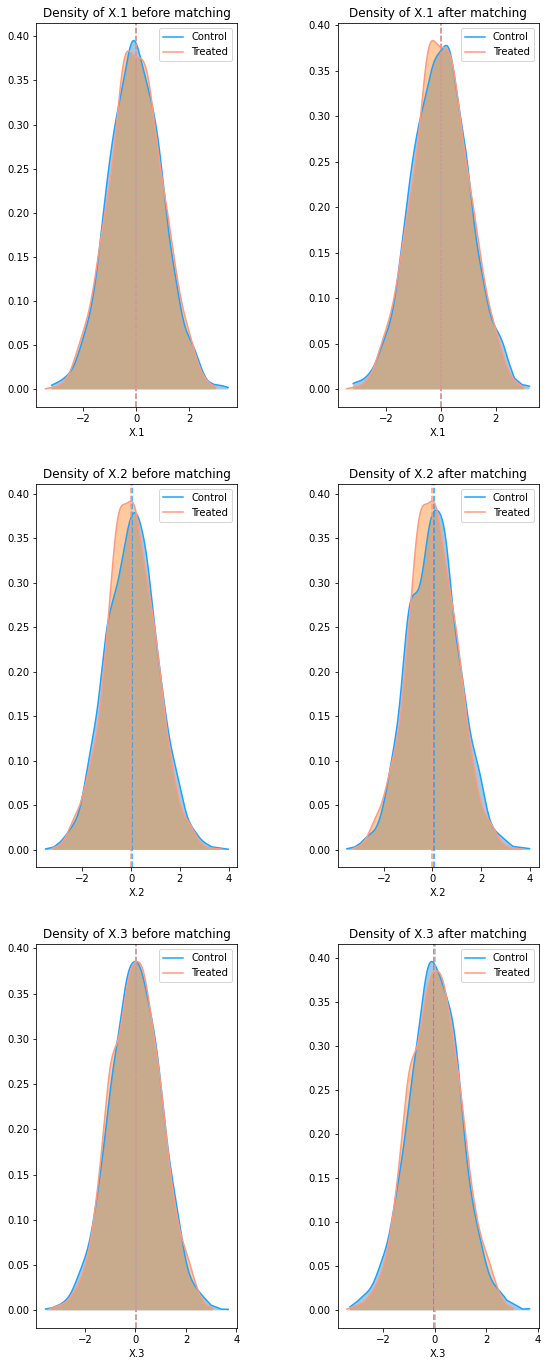

In [ ]:
graph = getDensityGraph(model.matching(), model.X_var, model.data)
fig, axs = plt.subplots(model.X_var.shape[1], 2, figsize=(model.X_var.shape[1]*3, model.X_var.shape[1]*8))
for j in range(model.X_var.shape[1]):    
    colname_j = model.X_var.columns.values[j] 
        
    # Plot the density of two population for absences before matching
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataControl"], graph[j]["Tables"]["BeforeMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataControl"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityControl"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 0].set_title("Density of " + colname_j + " before matching")
    axs[j, 0].set_xlabel(colname_j)
    axs[j, 0].legend();
            
    # Plot the density of two population for absences after matching
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataControl"], graph[j]["Tables"]["AfterMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataControl"], 0, graph[j]["Tables"]["AfterMatching"]["DensityControl"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataTreated"], graph[j]["Tables"]["AfterMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataTreated"], 0, graph[j]["Tables"]["AfterMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 1].set_title("Density of " +colname_j + " after matching")
    axs[j, 1].legend();
    axs[j, 1].set_xlabel(colname_j)
    plt.subplots_adjust(wspace=0.5, hspace=0.2)

## Test 2: Advanced options, method : GradientBoosting

In [ ]:
model = TreatmentEffect(X, Tr, Y, Estimator = "GradientBoosting")

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


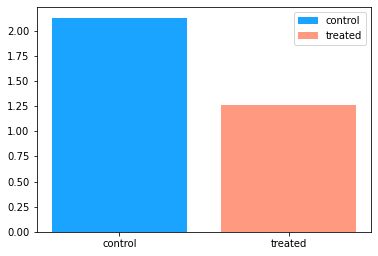

The observed treatment effect before Propensity Score Matching: -0.8711872762527668


In [ ]:
df_before = model.data                                                                       
ObsATElist = model.getObsTE()                                                               
Mean_tr = ObsATElist[0]                                                                   
Mean_ctrl = ObsATElist[1]                                                                

# Add a barplot
bars = ('control', 'treated')
height = [Mean_ctrl, Mean_tr]
y_pos = np.arange(len(bars))

plt.bar(y_pos[0], height[0], color="#1AA3FF", label=bars[0])
plt.bar(y_pos[1], height[1], color="#FF9980", label=bars[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.legend()
plt.show()

ObsATE = Mean_tr - Mean_ctrl                                                               
print("The observed treatment effect before Propensity Score Matching: " + str(ObsATE))

In [ ]:
model.TableOneBefore()

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grouped by Tr                                            
                      Missing     Overall           0           1 P-Value
n                                   10000        4991        5009        
X.1, mean (SD)              0  -0.0 (1.0)  -0.4 (0.9)   0.4 (0.9)  <0.001
X.2, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.214
X.3, mean (SD)              0   0.0 (1.0)   0.0 (1.0)   0.0 (1.0)   0.517
X.4, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.313
X.5, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)   0.0 (1.0)   0.780

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


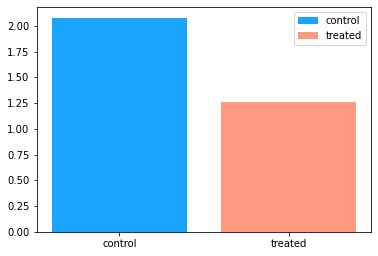

The Causal treatment effect after Propensity Score Matching: -0.8183763838439779


In [ ]:
df_after = model.data
ATElist = model.getATE()
Mean_tr = ATElist[0]
Mean_ctrl = ATElist[1]

# Add a barplot
bars = ('control', 'treated')
height = [Mean_ctrl, Mean_tr]
y_pos = np.arange(len(bars))

plt.bar(y_pos[0], height[0], color="#1AA3FF", label=bars[0])
plt.bar(y_pos[1], height[1], color="#FF9980", label=bars[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.legend()
plt.show()

CausalATE = Mean_tr - Mean_ctrl
print("The Causal treatment effect after Propensity Score Matching: " + str(CausalATE))    

In [ ]:
model.TableOneAfter()

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grouped by Tr                                            
                      Missing     Overall           0           1 P-Value
n                                   10014        5007        5007        
X.1, mean (SD)              0   0.4 (0.9)   0.4 (0.8)   0.4 (0.9)   0.050
X.2, mean (SD)              0   0.0 (1.0)   0.0 (1.0)  -0.0 (1.0)   0.093
X.3, mean (SD)              0  -0.0 (1.0)  -0.0 (0.9)   0.0 (1.0)   0.012
X.4, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.928
X.5, mean (SD)              0   0.0 (1.0)   0.0 (1.0)   0.0 (1.0)   0.913

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


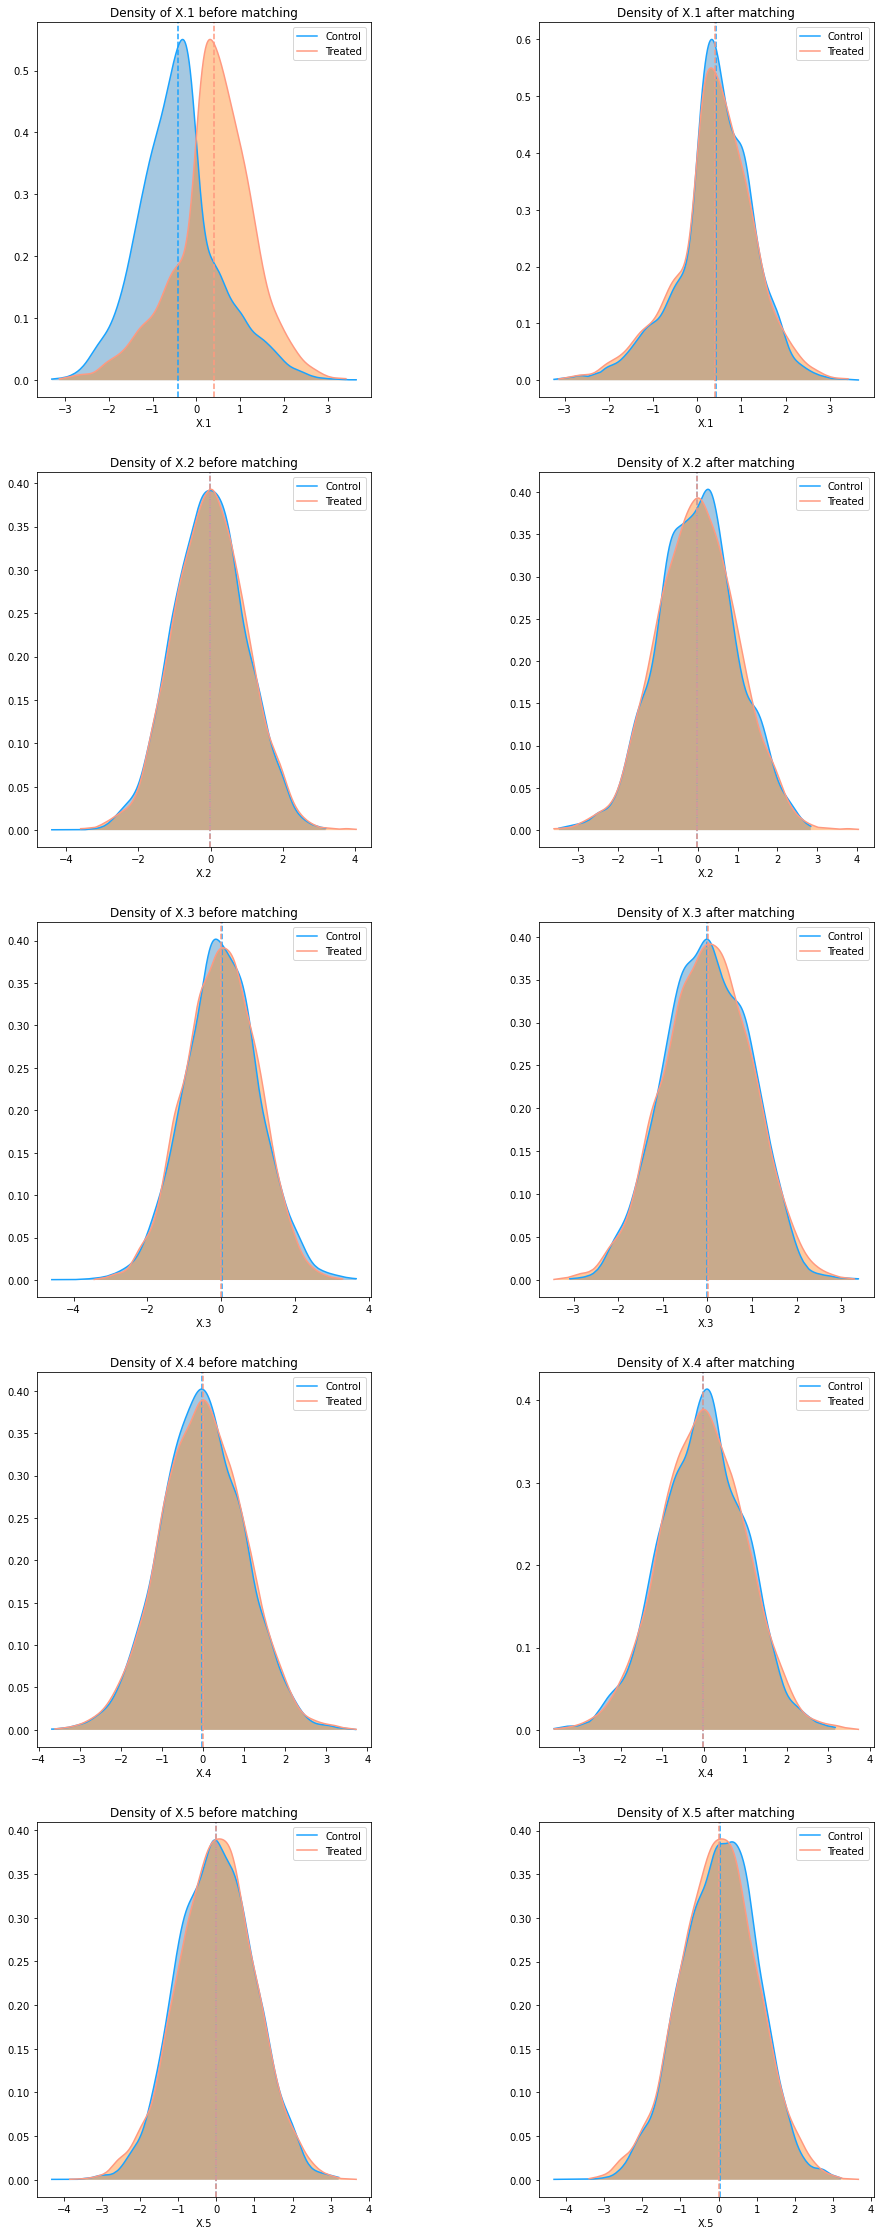

In [ ]:
graph = model.densityPoints()
fig, axs = plt.subplots(model.X_var.shape[1], 2, figsize=(model.X_var.shape[1]*3, model.X_var.shape[1]*8))
for j in range(model.X_var.shape[1]):    
    colname_j = model.X_var.columns.values[j] 
        
    # Plot the density of two population for absences before matching
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataControl"], graph[j]["Tables"]["BeforeMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataControl"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityControl"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 0].set_title("Density of " + colname_j + " before matching")
    axs[j, 0].set_xlabel(colname_j)
    axs[j, 0].legend();
            
    # Plot the density of two population for absences after matching
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataControl"], graph[j]["Tables"]["AfterMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataControl"], 0, graph[j]["Tables"]["AfterMatching"]["DensityControl"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataTreated"], graph[j]["Tables"]["AfterMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataTreated"], 0, graph[j]["Tables"]["AfterMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 1].set_title("Density of " +colname_j + " after matching")
    axs[j, 1].legend();
    axs[j, 1].set_xlabel(colname_j)
    plt.subplots_adjust(wspace=0.5, hspace=0.2)

## Test 3: Advanced options, method : RandomForest

In [ ]:
model = TreatmentEffect(X, Tr, Y, Estimator = "RandomForest")

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


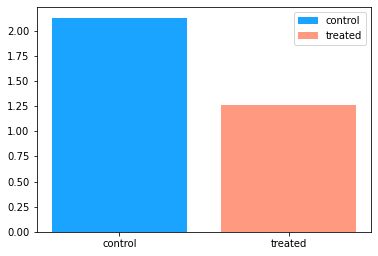

The Observed treatment effect before Propensity Score Matching: -0.8711872762527668


In [ ]:
df_before = model.data                                                                      
ObsATElist = model.getObsTE()                                                               
Mean_tr = ObsATElist[0]                                                                    
Mean_ctrl = ObsATElist[1]                                                                   

# Add a barplot
bars = ('control', 'treated')
height = [Mean_ctrl, Mean_tr]
y_pos = np.arange(len(bars))

plt.bar(y_pos[0], height[0], color="#1AA3FF", label=bars[0])
plt.bar(y_pos[1], height[1], color="#FF9980", label=bars[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.legend()
plt.show()

ObsATE = Mean_tr - Mean_ctrl                                                                  
print("The Observed treatment effect before Propensity Score Matching: " + str(ObsATE))

In [ ]:
model.TableOneBefore()

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grouped by Tr                                            
                      Missing     Overall           0           1 P-Value
n                                   10000        4991        5009        
X.1, mean (SD)              0  -0.0 (1.0)  -0.4 (0.9)   0.4 (0.9)  <0.001
X.2, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.214
X.3, mean (SD)              0   0.0 (1.0)   0.0 (1.0)   0.0 (1.0)   0.517
X.4, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)  -0.0 (1.0)   0.313
X.5, mean (SD)              0  -0.0 (1.0)  -0.0 (1.0)   0.0 (1.0)   0.780

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


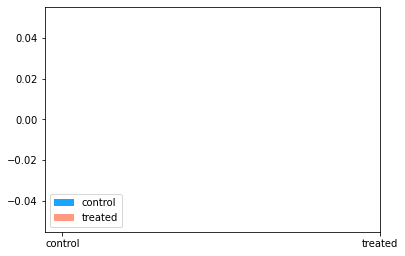

The Causal treatment effect after Propensity Score Matching: nan


In [ ]:
df_after = model.data
ATElist = model.getATE()
Mean_tr = ATElist[0]
Mean_ctrl = ATElist[1]

# Add a barplot
bars = ('control', 'treated')
height = [Mean_ctrl, Mean_tr]
y_pos = np.arange(len(bars))

plt.bar(y_pos[0], height[0], color="#1AA3FF", label=bars[0])
plt.bar(y_pos[1], height[1], color="#FF9980", label=bars[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.legend()
plt.show()

CausalATE = Mean_tr - Mean_ctrl
print("The Causal treatment effect after Propensity Score Matching: " + str(CausalATE))    

In [ ]:
model.TableOneAfter()

C:\Users\J0521353\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InputError: Input data is empty.

In [ ]:
graph = model.densityPoints()
fig, axs = plt.subplots(model.X_var.shape[1], 2, figsize=(model.X_var.shape[1]*3, model.X_var.shape[1]*8))
for j in range(model.X_var.shape[1]):    
    colname_j = model.X_var.columns.values[j] 
        
    # Plot the density of two population for absences before matching
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataControl"], graph[j]["Tables"]["BeforeMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataControl"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityControl"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 0].plot(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 0].fill_between(graph[j]["Tables"]["BeforeMatching"]["DataTreated"], 0, graph[j]["Tables"]["BeforeMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 0].axvline(graph[j]["Tables"]["BeforeMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 0].set_title("Density of " + colname_j + " before matching")
    axs[j, 0].set_xlabel(colname_j)
    axs[j, 0].legend();
            
    # Plot the density of two population for absences after matching
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataControl"], graph[j]["Tables"]["AfterMatching"]["DensityControl"], color = "#1AA3FF", label = "Control")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataControl"], 0, graph[j]["Tables"]["AfterMatching"]["DensityControl"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanControl"], color = "#1AA3FF", ls = '--')
    axs[j, 1].plot(graph[j]["Tables"]["AfterMatching"]["DataTreated"], graph[j]["Tables"]["AfterMatching"]["DensityTreated"], color = "#FF9980", label = "Treated")
    axs[j, 1].fill_between(graph[j]["Tables"]["AfterMatching"]["DataTreated"], 0, graph[j]["Tables"]["AfterMatching"]["DensityTreated"], alpha=0.4)
    axs[j, 1].axvline(graph[j]["Tables"]["AfterMatching"]["meanTreated"], color = "#FF9980", ls = '--')
    axs[j, 1].set_title("Density of " +colname_j + " after matching")
    axs[j, 1].legend();
    axs[j, 1].set_xlabel(colname_j)
    plt.subplots_adjust(wspace=0.5, hspace=0.2)

L'Algorithme 3 ne converge pas / ne donne pas de résultat précis avec la méthode RandomForest.